In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
data = np.load("D:\Work\Neurogenesis-PhD\synaptogenesis\case_1_revised.npz")

In [3]:
simtime = int(data['simtime'])
post_spikes = data['post_spikes']

In [4]:
count_spikes = np.zeros(256)
for id, time in post_spikes:
    count_spikes[int(id)] += 1

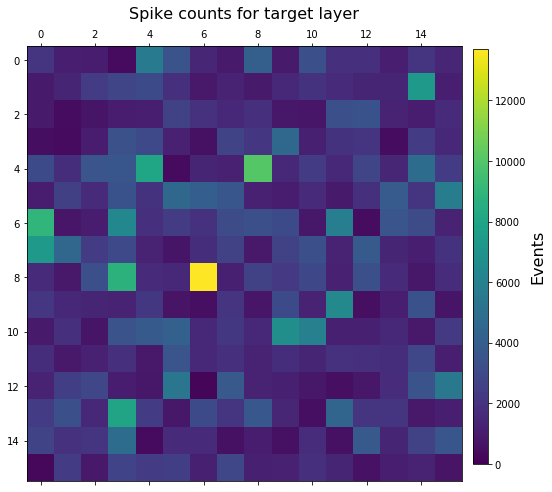

In [5]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(count_spikes.reshape(16,16), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Spike counts for target layer", fontsize=16)
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("Events", fontsize=16)

In [6]:
target_neuron_mean_spike_rate = count_spikes / float(simtime) * 1000.

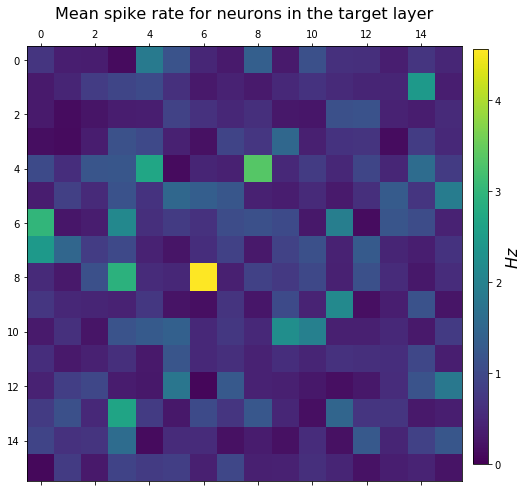

In [7]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(target_neuron_mean_spike_rate.reshape(16,16), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Mean spike rate for neurons in the target layer", fontsize=16)
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$Hz$", fontsize=16)

In [8]:
total_target_neuron_mean_spike_rate = np.mean(target_neuron_mean_spike_rate)
print "Target neuron spike rate", total_target_neuron_mean_spike_rate, "Hz"

Target neuron spike rate 0.755092447917 Hz


In [9]:
ff_weights= data['final_pre_weights']

In [10]:
init_ff_weights = data['init_ff_connections']

In [11]:
simdata = np.array(data['sim_params']).ravel()[0]
print simdata

{'t_record': 400, 'sigma_stim': 2, 'simtime': 3000000, 'f_base': 5, 'f_peak': 152, 'g_max': 0.2, 't_stim': 20}


In [12]:
ff_last = ff_weights.reshape(256,256)

In [13]:
number_ff_incoming_connections = np.count_nonzero(~np.isnan(ff_last), axis=0)
print number_ff_incoming_connections

[13 14 16 18  9 13 18 19 11 19 16 16 13 12 12 17 13 16 13 15 12 17 11 17 17
 17 12 16 16 17 12 18 15 11 17 17 16 17 14 16 20 14 15 15 15 14 17 14 20 14
 16 15 14 16 15 14 14 11 17 13 15 15 13 16 16 16 13 15 11 17 18 18 11 14 14
 14 15 12 15 15 17 17 16  9 16 11 18 15 17 17  9 14 14 10 15 12  9 16 14 10
 15 13 11 12 12 10 12 13 16 12 11 14 11 13 11 12 16 10 18 15 17 12 12 15 10
 15 14 13 18 12 11 10 18 17 10 12 14 19 13 13 12 16 13 11 15 13 19 16 11 12
 19 16 16 14 15 12 14 15 14 15 15 13 16 13 15 12 14 13 12  9  9 12 16 15 18
 12 15 16 16 15 17 15 16 17 16 14 16 12 15 11 14 19 15 11 14 15 16 13 11 13
 17 15 17 15 13 13 12 13 13 13 16 11 13 15 11 11 12 15 14 13 17 16 14  8 13
 12 16 10 15 13 14 17 13 18 14 17 16 16 14 13 14 15 17 13 13 15 16 13 14 13
 10 13 14 12 15 17]


In [14]:
final_mean_number_ff_synapses = np.mean(number_ff_incoming_connections)
print final_mean_number_ff_synapses

14.2109375


In [15]:
initial_weight_mean = np.nanmean(init_ff_weights)
print "Initial weight mean", initial_weight_mean

Initial weight mean 0.2


In [16]:
final_weight_mean = np.nanmean(ff_last)
print "Final weight mean", final_weight_mean

Final weight mean 0.0286223006288


In [17]:
print "Weight as proportion of max for the initial number of synapses", final_weight_mean  / initial_weight_mean

Weight as proportion of max for the initial number of synapses 0.143111503144


# Sigma aff
We are looking for a location around which the afferent synapses have the lowest weighted variance. 

For this, we iterate over neuron locations (then we look at inter-neuron locations as well [1/10th of the unit distance]) and sum over all existing synapses

I can have a vector of 256 values [2560 values] so np.argmin works 

In [23]:
# Wiring
n = 16
N_layer = n ** 2
S = (n, n)
# S = (256, 1)
grid = np.asarray(S)
def distance(x0, x1, grid=np.asarray([16, 16]), type='euclidian'):
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    delta = np.abs(x0 - x1)
    delta = np.where(delta > grid * .5, delta - grid, delta)

    if type == 'manhattan':
        return np.abs(delta).sum(axis=-1)
    return np.sqrt((delta ** 2).sum(axis=-1))

## Lowest weighted variance ($\sigma_{aff}^{2}$)

In [134]:
variances = np.ones((n,n)) * np.nan
for x in np.arange(n):
    top_sum = 0
    bottom_sum = 0
    for y in np.arange(n):
        active_synapses = np.argwhere(np.isfinite(ff_last[int(x * n + y), :])).ravel()
        bottom_sum = np.sum(ff_last[int(x * n + y), active_synapses])
        distances = np.zeros(active_synapses.size)
        for index in np.arange(active_synapses.size):
            distances[index] = distance((x, y), (active_synapses[index]//n, active_synapses[index]%n), grid)
        distances = distances ** 2
        top_sum = np.sum(np.multiply(distances, ff_last[int(x * n + y), active_synapses]))
        variances[int(x), int(y)] = float(top_sum) / bottom_sum
stds = np.sqrt(variances)
lowest_weighted_variance_location = (np.nanargmin(stds)//n, np.nanargmin(stds)%n)

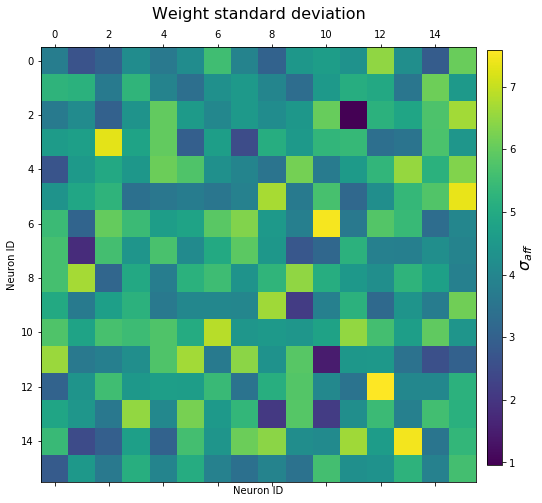

In [135]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(stds)
ax1.grid(visible=False)
ax1.set_title("Weight standard deviation", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [136]:
np.nanargmin(stds)

43

In [137]:
stds[np.nanargmin(stds)//n, np.nanargmin(stds)%n]

0.96749496723647455

In [138]:
np.mean(stds)

4.6403811442538769

## Absolute deviation (_AD_)

I have 1 preferred location for the entire network. Mean AD (I guess) means that I compute the distance from each neuron's ideal location to the 1 preferred location and take the mean of that. WCGW?

(The exact quote is ''Having calculated **the preferred location** for all the neurons in the target layer [...]''; it's not  ''the preferred location**s**'')

I'm still pretty sure there's supposed to be a preferred location for each target neuron...

In [143]:
distances = np.zeros(n**2)
for index in np.arange(distances.size):
    distances[index] = distance(lowest_weighted_variance_location, (index//n, index%n), grid)

In [145]:
distances

array([  5.38516481,   6.32455532,   7.28010989,   8.24621125,
         7.28010989,   6.32455532,   5.38516481,   4.47213595,
         3.60555128,   2.82842712,   2.23606798,   2.        ,
         2.23606798,   2.82842712,   3.60555128,   4.47213595,
         5.09901951,   6.08276253,   7.07106781,   8.06225775,
         7.07106781,   6.08276253,   5.09901951,   4.12310563,
         3.16227766,   2.23606798,   1.41421356,   1.        ,
         1.41421356,   2.23606798,   3.16227766,   4.12310563,
         5.        ,   6.        ,   7.        ,   8.        ,
         7.        ,   6.        ,   5.        ,   4.        ,
         3.        ,   2.        ,   1.        ,   0.        ,
         1.        ,   2.        ,   3.        ,   4.        ,
         5.09901951,   6.08276253,   7.07106781,   8.06225775,
         7.07106781,   6.08276253,   5.09901951,   4.12310563,
         3.16227766,   2.23606798,   1.41421356,   1.        ,
         1.41421356,   2.23606798,   3.16227766,   4.12

In [146]:
mean_AD = np.mean(distances)

In [147]:
print mean_AD

6.13903095224


# Alternative $\sigma_{aff}^{2}$

##$\sigma_{aff}^{2} = argmin_{\bar{x}} \frac{\Sigma_{i}w_{i}|\bar{p}_{xi}|^2}{\Sigma_{i}w_{i}}$

In [187]:
variances = np.ones((N_layer,N_layer)) * np.nan
preferred_locations = np.ones((n,n)) * np.nan
active_synapses_indices = np.where(np.isfinite(ff_last))
distances = np.ones((N_layer,N_layer)) * np.nan
bottom_sum = np.sum(ff_last[active_synapses_indices])
distances = np.ones((N_layer,N_layer)) * np.nan
for potential_preferred_location in np.arange(N_layer):
    for afferent_location in np.ndindex(grid[0], grid[1]):
        distances[potential_preferred_location, afferent_location[0]*n + afferent_location[1] ] = \
                distance((potential_preferred_location//n, potential_preferred_location%n), afferent_location, grid)**2

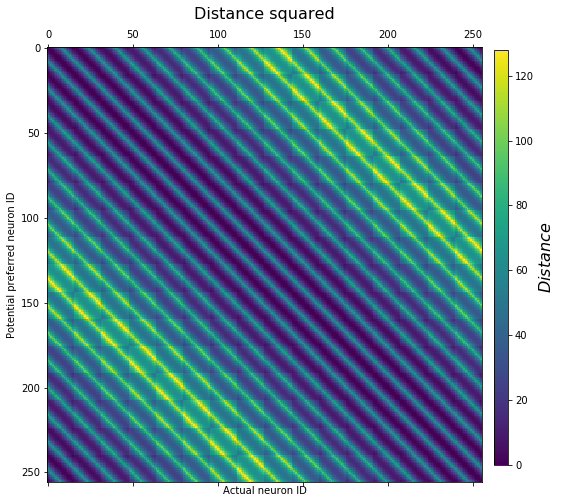

In [189]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(distances)
ax1.grid(visible=False)
ax1.set_title("Distance squared", fontsize=16)
ax1.set_xlabel("Actual neuron ID")
ax1.set_ylabel("Potential preferred neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$Distance$", fontsize=16)

In [192]:
weighted_distance = np.multiply(distances, ff_last)

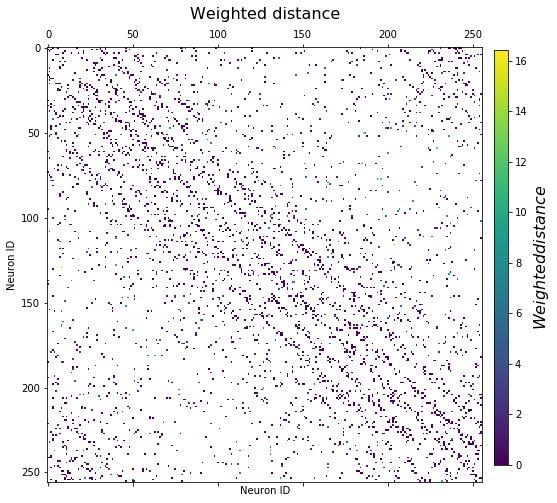

In [193]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(weighted_distance)
ax1.grid(visible=False)
ax1.set_title("Weighted distance", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$Weighted distance$", fontsize=16)

In [202]:
variance = np.nansum(weighted_distance, axis=1) / bottom_sum
variance = variance.reshape(16,16)

In [203]:
stds = np.sqrt(variance)
lowest_weighted_variance_location = (np.nanargmin(stds)//n, np.nanargmin(stds)%n)

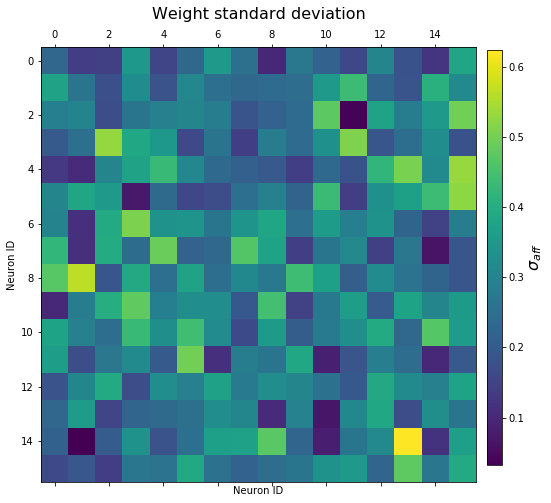

In [205]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(stds)
ax1.grid(visible=False)
ax1.set_title("Weight standard deviation", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [206]:
print "lowest_weighted_variance_location", lowest_weighted_variance_location

lowest_weighted_variance_location (14, 1)


In [207]:
print "mean stds", np.mean(stds)
print "min stds", stds[lowest_weighted_variance_location]

mean stds 0.283402800782
min stds 0.0329833983166
